In [37]:
import time
start_time = time.time()

# Librerías

In [38]:
# Librerías
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, 
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score, 
    log_loss, roc_curve
)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from IPython.display import display, HTML

# Funciones auxiliares

In [39]:
# Funciones auxiliares

def preprocess_dataset(dataset):
    """
    Elimina duplicados del dataset.
    
    Parámetros:
    - dataset (pd.DataFrame): Dataset a procesar.

    Retorna:
    - dataset (pd.DataFrame): Dataset sin duplicados.
    - duplicates_removed (int): Número de registros duplicados eliminados.
    """
    dataset_no_duplicates = dataset.drop_duplicates()
    duplicates_removed = len(dataset) - len(dataset_no_duplicates)
    return dataset_no_duplicates, duplicates_removed


def drop_columns_by_missing_threshold(dataset, missing_threshold=0.3):
    """
    Elimina columnas con un porcentaje de valores nulos superior al umbral.

    Parámetros:
    - dataset (pd.DataFrame): Dataset ya filtrado.
    - missing_threshold (float): Umbral de porcentaje de valores faltantes.

    Retorna:
    - dataset_cleaned (pd.DataFrame): Dataset con columnas eliminadas.
    - dropped_columns (list): Lista de nombres de columnas eliminadas.
    - missing_threshold (float): El umbral usado.
    - dropped_columns_info (dict): Diccionario con % de NaNs por columna eliminada.
    """
    # Normalizar strings vacíos
    dataset = dataset.replace(['None', 'none', '', 'nan', 'Nan', 'NaN'], np.nan)

    # Calcular % de NaNs
    missing_percentage = dataset.isnull().mean()
    columns_to_drop = missing_percentage[missing_percentage > missing_threshold].index.tolist()
    dropped_columns_info = {col: round(missing_percentage[col] * 100, 2) for col in columns_to_drop}

    # Eliminar columnas
    dataset_cleaned = dataset.drop(columns=columns_to_drop)

    return dataset_cleaned, columns_to_drop, missing_threshold, dropped_columns_info


def detect_variable_type(dataset, column):
    """
    Detecta automáticamente el tipo de una variable.
    
    Parameters:
    - dataset: pd.DataFrame, el dataset en el que se encuentra la columna.
    - column: str, nombre de la columna a analizar.
    
    Returns:
    - str, tipo de la variable ("Numérica", "Categórica Binaria", "Categórica No Binaria").
    """
    unique_values = dataset[column].nunique()
    
    if dataset[column].dtype == bool or unique_values == 2:
        return "Categórica Binaria"
    elif pd.api.types.is_numeric_dtype(dataset[column]):
        return "Numérica"
    else:
        return "Categórica No Binaria"
    

def convert_column_type(dataset: pd.DataFrame, column: str, new_type: str) -> None:
    """
    Convierte el tipo de una columna en un dataset según la selección del usuario.

    Parámetros:
    - dataset (pd.DataFrame): Dataset que contiene la columna a convertir.
    - column (str): Nombre de la columna a convertir.
    - new_type (str): Nuevo tipo de la variable ("Numérica", "Categórica Binaria", "Categórica No Binaria").

    Retorna:
    - None (la conversión se realiza directamente en el dataset).
    """
    try:
        if new_type == "Numérica":
            dataset[column] = pd.to_numeric(dataset[column], errors='coerce')
        
        elif new_type == "Categórica Binaria":
            dataset[column] = dataset[column].astype(str).astype("category")
        
        elif new_type == "Categórica No Binaria":
            dataset[column] = dataset[column].astype(str).astype("category")

    except Exception as e:
        print(f"❌ Error al convertir la columna '{column}' a {new_type}: {e}")


def aplicar_transformaciones(dataset: pd.DataFrame, variable_types: dict, 
                             variables_a_numerica: list, variables_a_categorica_binaria: list, 
                             variables_a_categorica_no_binaria: list):
    """
    Aplica transformaciones de tipos de datos a las columnas de un dataset.

    Parámetros:
    - dataset (pd.DataFrame): El dataset con las columnas a transformar.
    - variable_types (dict): Diccionario con los tipos de variables actuales.
    - variables_a_numerica (list): Lista de columnas a convertir a tipo "Numérica".
    - variables_a_categorica_binaria (list): Lista de columnas a convertir a "Categórica Binaria".
    - variables_a_categorica_no_binaria (list): Lista de columnas a convertir a "Categórica No Binaria".

    Retorna:
    - dataset (pd.DataFrame): Dataset con las transformaciones aplicadas.
    - variable_types (dict): Diccionario actualizado con los nuevos tipos de variables.
    """

    cambios_realizados = []

    # Aplicar transformaciones según las listas de columnas
    for col in variables_a_numerica:
        if col in dataset.columns:
            try:
                convert_column_type(dataset, col, "Numérica")
                variable_types[col] = "Numérica"
                cambios_realizados.append(f"{col} → Numérica")
            except Exception as e:
                print(f"Error al convertir '{col}' a Numérica: {e}")

    for col in variables_a_categorica_binaria:
        if col in dataset.columns:
            try:
                convert_column_type(dataset, col, "Categórica Binaria")
                variable_types[col] = "Categórica Binaria"
                cambios_realizados.append(f"{col} → Categórica Binaria")
            except Exception as e:
                print(f"Error al convertir '{col}' a Categórica Binaria: {e}")

    for col in variables_a_categorica_no_binaria:
        if col in dataset.columns:
            try:
                convert_column_type(dataset, col, "Categórica No Binaria")
                variable_types[col] = "Categórica No Binaria"
                cambios_realizados.append(f"{col} → Categórica No Binaria")
            except Exception as e:
                print(f"Error al convertir '{col}' a Categórica No Binaria: {e}")

    # Mostrar resumen de los cambios
    if cambios_realizados:
        print("\nTransformaciones realizadas:")
        for cambio in cambios_realizados:
            print(f" - {cambio}")
    else:
        print("\nNo se realizaron cambios en los tipos de datos.")

    # Mostrar el estado final de los tipos de variables
    print("\nTipos de Variables Finales:")
    for col, var_type in variable_types.items():
        print(f"  {col}: {var_type}")

    return dataset, variable_types


def remove_suffix(col_name: str) -> str:
    """
    Elimina el último sufijo separado por guion bajo (_) en un nombre de columna.

    Parámetros:
    - col_name (str): Nombre de la columna.

    Retorna:
    - str: Nombre de la columna sin el último sufijo.
    """
    return col_name.rsplit("_", 1)[0] if "_" in col_name else col_name


def update_predictor_lists(df, fixed_predictors, candidate_predictors):
    """
    Actualiza las listas de predictores fijos y candidatos según los nombres de las columnas en el DataFrame.

    Parámetros:
    - df (pd.DataFrame): DataFrame con las columnas a analizar.
    - fixed_predictors (list): Lista de prefijos para los predictores fijos.
    - candidate_predictors (list): Lista de prefijos para los predictores candidatos.

    Retorna:
    - tuple:
        - updated_fixed (list): Lista de predictores fijos encontrados en el DataFrame.
        - updated_candidates (list): Lista de predictores candidatos encontrados en el DataFrame.
    """
    # Filtrar columnas que inician con los prefijos dados
    updated_fixed = list(set(col for col in df.columns if any(col.startswith(prefix) for prefix in fixed_predictors)))
    updated_candidates = list(set(col for col in df.columns if any(col.startswith(prefix) for prefix in candidate_predictors)))

    return updated_fixed, updated_candidates


def seleccion_forward(df, variables_fijas, variables_candidatas, objetivo, tipo_modelo='lineal', 
                      missing_data_handling='1', max_predictors=10, nivel_confianza=0.95):
    """
    Realiza una selección de variables hacia adelante (Forward Selection) basada en criterios estadísticos.

    Parámetros:
    - df (pd.DataFrame): DataFrame con las variables predictoras y la variable objetivo.
    - variables_fijas (list): Lista de variables que siempre deben estar en el modelo.
    - variables_candidatas (list): Lista de variables candidatas para la selección.
    - objetivo (str): Nombre de la variable objetivo.
    - tipo_modelo (str, opcional): Tipo de modelo a ajustar ("lineal" para regresión OLS, "logistica" para regresión logística).
    - missing_data_handling (str, opcional): Manejo de valores faltantes ('1' para eliminar filas con nulos).
    - max_predictors (int, opcional): Número máximo de predictores a seleccionar.
    - nivel_confianza (float, opcional): Nivel de confianza para la selección de variables (0.95 por defecto).

    Retorna:
    - dict: Un diccionario con:
        - 'mejores_variables': (list) Lista de las mejores variables seleccionadas.
        - 'mejor_criterio': (float) Valor óptimo del criterio de selección (BIC o AUC-ROC).
        - 'df_filtrado': (pd.DataFrame) DataFrame con las variables seleccionadas y sin valores nulos.
    """
    variables_modelo = list(variables_fijas)
    candidatas_restantes = list(variables_candidatas)
    
    # Inicializar los valores óptimos según el tipo de modelo
    if tipo_modelo == 'lineal':
        mejor_criterio = float('inf')  # Para BIC, menor es mejor
    elif tipo_modelo == 'logistica':
        mejor_criterio = 0  # Para AUC-ROC, mayor es mejor
    else:
        raise ValueError("El tipo_modelo debe ser 'lineal' o 'logistica'.")

    while candidatas_restantes and len(variables_modelo) < max_predictors:
        mejor_variable = None
        criterio_actual = None

        for variable in candidatas_restantes:
            variables_prueba = variables_modelo + [variable]
            X = df[variables_prueba].copy()

            if missing_data_handling == '1':
                X.dropna(inplace=True)

            # Asegurar que y tenga el mismo índice que X después de dropna()
            y = df.loc[X.index, objetivo]

            try:
                X = sm.add_constant(X.astype(float))
                y = y.astype(float)

                if tipo_modelo == 'lineal':
                    modelo = sm.OLS(y, X).fit()
                    criterio_actual = modelo.bic  # Se usa BIC para selección
                    p_valores = modelo.pvalues  # Obtener p-valores de todas las variables

                elif tipo_modelo == 'logistica':
                    modelo = sm.Logit(y, X).fit(disp=0)
                    y_pred_prob = modelo.predict(X)
                    criterio_actual = roc_auc_score(y, y_pred_prob)  # Se usa AUC-ROC para selección
                    p_valores = modelo.pvalues  # Obtener p-valores de todas las variables
                
                # Verificar si alguna variable tiene p-valor > (1 - nivel_confianza)
                variables_no_significativas = [var for var, p in p_valores.items() if p > (1 - nivel_confianza)]
                if 'const' in variables_no_significativas:
                    variables_no_significativas.remove('const')

                # Solo considerar la variable si es significativa y el criterio es válido
                if not variables_no_significativas:
                    if isinstance(criterio_actual, float) and not np.isnan(criterio_actual):
                        if (tipo_modelo == 'lineal' and criterio_actual < mejor_criterio) or \
                        (tipo_modelo == 'logistica' and criterio_actual > mejor_criterio):
                            mejor_criterio = criterio_actual
                            mejor_variable = variable

            except np.linalg.LinAlgError:
                # print(f"⛔ '{variable}' ignorada por matriz singular.")
                continue
            except Exception as e:
                print(f"⚠️ Error inesperado al procesar '{variable}': {e}")
                continue


        if mejor_variable:
            print(f"✅ Se agrega la variable: {mejor_variable}")
            variables_modelo.append(mejor_variable)
            candidatas_restantes.remove(mejor_variable)
        else:
            print("\n🚫 No se encontraron variables adicionales significativas. Se detiene la selección.")
            break

    # Filtrar el DataFrame con las mejores variables y eliminar valores nulos
    df_filtrado = df[variables_modelo + [objetivo]].dropna()
    
    print("\n🔍 Variables finales seleccionadas:")
    print(", ".join(variables_modelo))

    return {
        'mejores_variables': variables_modelo,
        'mejor_criterio': mejor_criterio,
        'df_filtrado': df_filtrado
    }


def filter_dataset(dataset: pd.DataFrame, variable_types: dict, filters: list) -> pd.DataFrame:
    """
    Aplica múltiples filtros a un dataset según las condiciones definidas, 
    incluyendo soporte para condiciones OR entre columnas y soporte flexible
    para filtros 'Categorías' tanto con valores individuales como listas.
    """
    if not filters:
        print("⚠️ No se han aplicado filtros al dataset.")
        return dataset
    
    original_rows = dataset.shape[0]
    dataset_filtered = dataset.copy()

    for selected_var, filter_type, filter_values in filters:
        try:
            # --- Filtro OR entre varias columnas ---
            if isinstance(selected_var, (tuple, list)):
                if filter_type != "Categorías":
                    print(f"⚠️ El tipo de filtro '{filter_type}' no es compatible con múltiples columnas. Filtro omitido.")
                    continue

                # Si filter_values no es lista o tupla, convertirlo a lista
                if not isinstance(filter_values, (list, tuple)):
                    filter_values = [filter_values]

                # Crear máscara OR entre columnas
                mask = False
                for col in selected_var:
                    if col not in dataset_filtered.columns:
                        print(f"⚠️ Columna '{col}' no encontrada. Omitida del filtro OR.")
                        continue
                    mask |= dataset_filtered[col].astype(str).str.strip().str.lower().isin(
                        [str(val).strip().lower() for val in filter_values]
                    )
                dataset_filtered = dataset_filtered[mask]

            # --- Filtro estándar ---
            else:
                if selected_var not in dataset_filtered.columns:
                    print(f"⚠️ Advertencia: Variable '{selected_var}' no encontrada en el dataset. Filtro omitido.")
                    continue

                if filter_type == "Igual":
                    dataset_filtered = dataset_filtered[dataset_filtered[selected_var] == filter_values]
                
                elif filter_type == "Mayor o igual":
                    dataset_filtered = dataset_filtered[dataset_filtered[selected_var] >= filter_values]

                elif filter_type == "Menor o igual":
                    dataset_filtered = dataset_filtered[dataset_filtered[selected_var] <= filter_values]

                elif filter_type == "Mayor":
                    dataset_filtered = dataset_filtered[dataset_filtered[selected_var] > filter_values]

                elif filter_type == "Menor":
                    dataset_filtered = dataset_filtered[dataset_filtered[selected_var] < filter_values]

                elif filter_type == "Entre":
                    if isinstance(filter_values, (tuple, list)) and len(filter_values) == 2:
                        dataset_filtered = dataset_filtered[
                            (dataset_filtered[selected_var] >= filter_values[0]) & 
                            (dataset_filtered[selected_var] <= filter_values[1])
                        ]
                    else:
                        print(f"⚠️ El filtro 'Entre' requiere una tupla o lista con 2 valores. Filtro omitido para '{selected_var}'.")

                elif filter_type == "Categorías":
                    # ✅ Aquí la mejora: si viene un solo valor (str/number), lo convertimos en lista
                    if not isinstance(filter_values, (list, tuple)):
                        filter_values = [filter_values]

                    dataset_filtered = dataset_filtered[
                        dataset_filtered[selected_var].astype(str).str.strip().str.lower().isin(
                            [str(val).strip().lower() for val in filter_values]
                        )
                    ]

                else:
                    print(f"⚠️ Tipo de filtro '{filter_type}' no reconocido para '{selected_var}'. Filtro omitido.")

        except Exception as e:
            print(f"❌ Error al aplicar filtro '{filter_type}' en '{selected_var}': {e}")
            continue

    filtered_rows = dataset_filtered.shape[0]

    # Mostrar resumen de filtros aplicados
    print("\n✅ Filtros aplicados:")
    for selected_var, filter_type, filter_values in filters:
        print(f" - {selected_var} → {filter_type}: {filter_values}")

    print(f"\n📊 El dataset ha pasado de {original_rows} filas a {filtered_rows} filas después de aplicar los filtros.")

    return dataset_filtered

# Función para calcular el intervalo de confianza usando z-score
def compute_confidence_interval(proportion, n, z=1.96):
    """
    Calcula el intervalo de confianza para una proporción utilizando la fórmula del z-score.

    Parámetros:
    - proportion (float): Valor de la métrica (por ejemplo, precisión o recall).
    - n (int): Número de observaciones (muestra).
    - z (float, opcional): Valor crítico del z-score (1.96 por defecto para 95% de confianza).

    Retorna:
    - tuple[float, float] | tuple[None, None]: Límite inferior y superior del intervalo de confianza,
      o (None, None) si n = 0.
    """
    if n == 0:
      return (None, None)
    proportion = max(0, min(proportion, 1))  # Forzar el rango correcto
    stderr = sqrt((proportion * (1 - proportion)) / n)
    lower_bound = proportion - z * stderr
    upper_bound = proportion + z * stderr
    return lower_bound, upper_bound

def evaluate_model(y_test, y_pred, target_type, threshold, confidence, z=1.96):
    """
    Evalúa un modelo de clasificación o regresión con métricas estándar e intervalos de confianza usando z-score.

    Parámetros:
    - y_test (pd.Series | np.ndarray): Valores reales de la variable objetivo.
    - y_pred (pd.Series | np.ndarray): Predicciones del modelo (probabilidades o valores continuos).
    - target_type (str): Tipo de variable objetivo: "Categórica Binaria" o "Numérica".
    - threshold (float): Umbral para convertir probabilidades en clases en clasificación (por defecto 0.5).
    - confidence (float): Nivel de confianza deseado para los intervalos (por defecto 0.95).
    - z (float, opcional): Valor crítico del z-score para el intervalo (por defecto 1.96, equivalente a 95%).

    Retorna:
    - dict: Diccionario con métricas del modelo y sus intervalos de confianza.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    n = len(y_test)  # Tamaño del conjunto de prueba

    if target_type == "Categórica Binaria":

        # Convertir probabilidades en clases
        y_pred_class = (y_pred >= threshold).astype(int)

        # Mostrar el threshold
        display_threshold_text(threshold)

        # Mostrar la matriz de confusión estilizada
        print("\n📊 Matriz de Confusión:")
        display_confusion_matrix(y_test, y_pred_class)

        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred_class)
        precision = precision_score(y_test, y_pred_class, zero_division=0)
        recall = recall_score(y_test, y_pred_class, zero_division=0)
        specificity = recall_score(y_test, y_pred_class, pos_label=0, zero_division=0)
        f1 = f1_score(y_test, y_pred_class, zero_division=0)
        auc = roc_auc_score(y_test, y_pred)
        logloss = log_loss(y_test, y_pred)

        # Intervalos de confianza con z-score
        confidence_intervals = {
            "Accuracy": compute_confidence_interval(accuracy, n, z),
            "Precision": compute_confidence_interval(precision, n, z),
            "Recall": compute_confidence_interval(recall, n, z),
            "Specificity": compute_confidence_interval(specificity, n, z),
            "F1": compute_confidence_interval(f1, n, z),
            "AUC": compute_confidence_interval(auc, n, z)
        }

        # Crear diccionario con resultados
        results_dict = {
            "n": n,
            "Accuracy": (accuracy, confidence_intervals["Accuracy"]),
            "Precision": (precision, confidence_intervals["Precision"]),
            "Recall": (recall, confidence_intervals["Recall"]),
            "Specificity": (specificity, confidence_intervals["Specificity"]),
            "F1": (f1, confidence_intervals["F1"]),
            "AUC": (auc, confidence_intervals["AUC"]),
            "LogLoss": logloss
        }

        # Mostrar la tabla estilizada con las métricas
        print("\n📈 Métricas del modelo:")
        display_metrics_table(results_dict)

        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='#7030A0', label=f"AUC = {auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.title("Curva ROC")
        plt.xlabel("1 - Especificidad")
        plt.ylabel("Sensibilidad")
        plt.legend()
        plt.show()

        return results_dict

    elif target_type == "Numérica":
        print("\n📊 Evaluación del modelo de regresión:")

        # Calcular métricas
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Crear diccionario con resultados
        results_dict = {
            "n": n,
            "MSE": mse,
            "MAE": mae,
            "R2": r2,
        }

        # Mostrar la tabla estilizada con las métricas
        print("\n📈 Métricas del modelo:")
        display_metrics_table(results_dict)

        return results_dict

    else:
        raise ValueError("El parámetro 'target_type' debe ser 'Numérica' o 'Categórica Binaria'.")
    

def create_dict_variables(dataset: pd.DataFrame, variable_types: dict) -> dict:
    """
    Crea un diccionario con las variables categóricas y sus respectivas categorías únicas.

    Parámetros:
    - dataset (pd.DataFrame): Dataset original antes de One-Hot Encoding.
    - variable_types (dict): Diccionario con los tipos de variables.

    Retorna:
    - dict: Diccionario con variables categóricas y sus categorías únicas.
    """
    dict_variables = {}

    for var, var_type in variable_types.items():
        if var not in dataset.columns:
            print(f"⚠️ Advertencia: La variable '{var}' no está presente en el dataset. Se omitirá.")
            continue

        if var_type.startswith("Categórica"):  # Filtra solo las variables categóricas
            unique_values = dataset[var].dropna().astype(str).unique().tolist()
            dict_variables[var] = unique_values

    return dict_variables


def find_best_threshold(y_true, y_pred_probs):
    """
    Encuentra el mejor umbral para la clasificación basado en la métrica F1-score.

    Parámetros:
    - y_true (array-like): Valores reales (0 o 1).
    - y_pred_probs (array-like): Probabilidades de predicción.

    Retorna:
    - float: Mejor umbral encontrado.
    """
    if not np.all(np.isin(y_true, [0, 1])):
        raise ValueError("⚠️ Error: y_true debe contener solo valores 0 y 1.")

    if np.isnan(y_pred_probs).any():
        raise ValueError("⚠️ Error: y_pred_probs contiene valores NaN.")

    thresholds = np.linspace(0.1, 0.9, num=81)

    # Calcular F1-score para cada threshold
    f1_scores = [f1_score(y_true, (y_pred_probs >= t).astype(int), zero_division=0) for t in thresholds]

    # Obtener el threshold con el F1-score más alto
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]

    return best_threshold


def generate_subgroup_name(subgroup_filters):
    """
    Genera un nombre de subgrupo basado en los filtros aplicados.

    Parámetros:
    - subgroup_filters (list): Lista de tuplas con (variable, filter_type, values)

    Retorna:
    - str: Nombre del subgrupo formateado.
    """
    subgroup_parts = []

    for variable, filter_type, values in subgroup_filters:
        # Convertimos `values` a string, manejando correctamente listas, tuplas y otros tipos
        if isinstance(values, (list, tuple)):
            if filter_type == "Entre" and len(values) == 2:
                values_str = f"({values[0]}-{values[1]})"  # Formato para rango
            else:
                values_str = "_".join(map(str, values))  # Convierte listas y tuplas a string separado por "_"
        else:
            values_str = str(values)  # Convierte números o strings directamente

        # Determinar el formato según `filter_type`
        if filter_type == "Categorías":
            subgroup_parts.append(f"{variable}:{values_str}")  # Formato más legible
        elif filter_type == "Mayor o igual":
            subgroup_parts.append(f"{variable}≥{values_str}")
        elif filter_type == "Menor o igual":
            subgroup_parts.append(f"{variable}≤{values_str}")
        elif filter_type == "Mayor":
            subgroup_parts.append(f"{variable}>{values_str}")
        elif filter_type == "Menor":
            subgroup_parts.append(f"{variable}<{values_str}")
        elif filter_type == "Igual":
            subgroup_parts.append(f"{variable}={values_str}")
        elif filter_type == "Entre":
            subgroup_parts.append(f"{variable}{values_str}")

    # Unimos todas las partes con ` & ` en caso de múltiples condiciones
    return " & ".join(subgroup_parts)


def combine_results_for_forest_plot(model_results, subgroups_results):
    """
    Combina los resultados del modelo principal y los subgrupos en un solo diccionario
    para usarlos en el forest plot, incluyendo todas las métricas.

    Parámetros:
    - model_results (dict): Resultados del modelo principal.
    - subgroups_results (dict): Resultados de los subgrupos.

    Retorna:
    - dict: Diccionario combinado con los resultados.
    """
    return {"Modelo Principal": model_results, **subgroups_results}

def order_models(model_results, subgroups_results, metric_names, min_values, main_model):
    """
    Ordena los modelos de acuerdo a los criterios especificados.
    """
    combined_results = {main_model: model_results, **subgroups_results}
    highlighted_models = []
    remaining_models = []
    
    for model, results in subgroups_results.items():
        superior_metric = False
        inferior_metric = False
        outside_rejection = True
        
        for metric in metric_names:
            if metric not in results or metric not in model_results:
                continue
            
            model_value, (model_lower, model_upper) = results[metric]["value"], results[metric]["conf_int"]
            main_value, (main_lower, main_upper) = model_results[metric]["value"], model_results[metric]["conf_int"]
            rejection_zone = min_values.get(metric, 0) if min_values else 0
            
            # Condición de rendimiento superior
            if model_lower > main_upper:
                superior_metric = True
            
            # Condición de rendimiento inferior
            if model_upper < main_lower:
                inferior_metric = True
            
            # Verificar si el IC está completamente fuera de la zona de rechazo
            if model_lower < rejection_zone:
                outside_rejection = False
        
        # Clasificar modelos según las condiciones
        if superior_metric and not inferior_metric and outside_rejection:
            highlighted_models.append(model)
        else:
            remaining_models.append(model)
    
    # Orden final: Modelos destacados primero, luego el Modelo Principal, después los restantes
    ordered_models = highlighted_models + [main_model] + remaining_models
    return ordered_models

def forest_plot(model_results, subgroups_results, metric_names, target, 
                min_values=None, main_model='Modelo Principal', model_name="Comparación de Modelos"):
    """
    Genera múltiples Forest Plots ordenando modelos según rendimiento.
    """
    # Métricas mínimas requeridas para visualizar un subgrupo
    metricas_requeridas = ["Accuracy", "Precision", "Recall", "Specificity", "F1", "AUC"]

    # Limpiar subgrupos incompletos
    subgroups_results = {
        name: results for name, results in subgroups_results.items()
        if results and all(m in results for m in metricas_requeridas)
    }

    # Eliminar subgrupos con n < 30
    subgroups_results = {
        name: results for name, results in subgroups_results.items()
        if 'n' in results and results['n']['value'] >= 30
    }
    
    # Reemplazar 'Recall' por 'Sensibility' solo para la visualización
    metric_names_display = ['Sensibility' if metric == 'Recall' else metric for metric in metric_names]
    
    num_metrics = len(metric_names)
    ordered_models = order_models(model_results, subgroups_results, metric_names, min_values, main_model)
    
    fig, axes = plt.subplots(1, num_metrics, figsize=(num_metrics * 5, max(5, len(ordered_models) * 0.5 + 2)), sharey=True)
    if num_metrics == 1:
        axes = [axes]
    
    combined_results = {m: model_results if m == main_model else subgroups_results[m] for m in ordered_models}
    labels_with_n = [
        f"{m} (n={combined_results[m]['n']['value']})" if 'n' in combined_results[m] else m
        for m in ordered_models
    ]
    y_positions = np.arange(len(ordered_models))
    
    for ax, (metric_name, metric_display) in zip(axes, zip(metric_names, metric_names_display)):
        values = np.array([combined_results[m][metric_name]["value"] for m in ordered_models])
        conf_intervals = np.array([combined_results[m][metric_name]["conf_int"] for m in ordered_models])
        lower_bounds, upper_bounds = conf_intervals[:, 0], conf_intervals[:, 1]
        
        if min_values and metric_name in min_values:
            ax.axvspan(0, min_values[metric_name], color='#FF8787', alpha=0.3)
        
        ax.errorbar(values, y_positions, xerr=[values - lower_bounds, upper_bounds - values], 
                    fmt='o', color='#FFC000', ecolor='black', elinewidth=2, capsize=4)
        
        if main_model in combined_results and metric_name in combined_results[main_model]:
            main_lower, main_upper = combined_results[main_model][metric_name]["conf_int"]
            ax.axvline(x=main_lower, linestyle='--', color='#7030A0', linewidth=1)
            ax.axvline(x=main_upper, linestyle='--', color='#7030A0', linewidth=1)
        
        if min_values and metric_name in min_values:
            ax.axvline(x=min_values[metric_name], linestyle='-', color='#FF0000', linewidth=2)
        
        # Construir título con el valor mínimo si está disponible
        min_value_text = f" (Valor Mínimo: {min_values[metric_name]:.2f})" if min_values and metric_name in min_values else ""
        ax.set_title(f"{metric_display}{min_value_text}")
        
        ax.set_xlim(0, 1)
        ax.set_xlabel(metric_display)
        ax.grid(True, linestyle='--', alpha=0.5)
    
    axes[0].set_yticks(y_positions)
    axes[0].set_yticklabels([f"{m}" if m != main_model else f"{m}" for m in labels_with_n])
    for label, model in zip(axes[0].get_yticklabels(), ordered_models):
        if model == main_model:
            label.set_fontweight("bold")
    
    axes[0].invert_yaxis()
    
    fig.suptitle(f"{model_name} - Target: {target}", fontsize=14, fontweight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Mostrar la leyenda
    display_forest_plot_legend()
    

def display_styled_table(variables_dict):
    """
    Función para mostrar un diccionario como una tabla estilizada en Jupyter Notebook.

    Parámetros:
    - variables_dict (dict): Diccionario donde las claves son los nombres de las variables
      y los valores son sus descripciones.

    Retorna:
    - None (Muestra la tabla directamente en Jupyter Notebook).
    """
    # Convertir el diccionario a un DataFrame
    df_variables = pd.DataFrame(list(variables_dict.items()), columns=["Variable", "Descripción"])

    # Aplicar estilo a la tabla con la columna "Descripción" centrada correctamente
    styled_table = df_variables.style.set_properties(**{
        'background-color': '#F4F4F4',
        'border': '1px solid black',
        'color': 'black',
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#7030A0'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('padding', '5px'), ('text-align', 'center')]}  # Centrar todas las celdas de datos
    ])

    # Mostrar la tabla
    display(styled_table)


def display_confusion_matrix(y_true, y_pred_class):
    """
    Muestra la matriz de confusión en un formato estilizado en Jupyter Notebook.

    Parámetros:
    - y_true (array-like): Valores reales de la variable objetivo.
    - y_pred_class (array-like): Predicciones del modelo (clases).

    Retorna:
    - None (Muestra la tabla directamente en Jupyter Notebook).
    """
    # Calcular la matriz de confusión
    unique_labels = sorted(np.unique(np.concatenate((y_true, y_pred_class))))
    cm = confusion_matrix(y_true, y_pred_class, labels=unique_labels)

    # Convertir en DataFrame para visualización
    cm_df = pd.DataFrame(cm, 
                         columns=[f"Predicción {label}" for label in unique_labels], 
                         index=[f"Real {label}" for label in unique_labels])

    # Aplicar estilo a la tabla
    styled_cm = cm_df.style.set_properties(**{
        'background-color': '#F4F4F4',
        'border': '1px solid black',
        'color': 'black',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#7030A0'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('padding', '5px')]}
    ])

    # Mostrar la tabla
    display(styled_cm)


def display_metrics_table(metrics_dict):
    """
    Muestra las métricas del modelo en una tabla estilizada con columnas:
    'Métrica', 'Valor' y 'Intervalo de confianza', excluyendo 'n' y 'LogLoss'.

    Parámetros:
    - metrics_dict (dict): Diccionario con métricas y sus intervalos de confianza.

    Retorna:
    - None (Muestra la tabla directamente en Jupyter Notebook).
    """
    # Excluir 'n' y 'LogLoss' de la tabla
    metrics_data = []
    conf_intervals = []

    for metric, value in metrics_dict.items():
        if metric in ["n", "LogLoss"]:
            continue  # Saltar estas métricas

        if isinstance(value, tuple):  # Si tiene intervalo de confianza
            metric_value, conf_interval = value
            if conf_interval[0] is not None:
                conf_interval_str = f"[{conf_interval[0]:.2f}, {conf_interval[1]:.2f}]"
            else:
                conf_interval_str = "N/A"
        else:
            metric_value = value
            conf_interval_str = "N/A"

        metrics_data.append([metric, f"{metric_value:.2f}", conf_interval_str])
        conf_intervals.append(conf_interval_str)

    # Crear DataFrame
    df_metrics = pd.DataFrame(metrics_data, columns=["Métrica", "Valor", "Intervalo de confianza"])

    # Eliminar columna si todos los intervalos son N/A
    if all(ci == "N/A" for ci in conf_intervals):
        df_metrics = df_metrics.drop(columns=["Intervalo de confianza"])

    # Aplicar estilo a la tabla
    styled_metrics_table = df_metrics.style.set_properties(**{
        'background-color': '#F4F4F4',
        'border': '1px solid black',
        'color': 'black',
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#7030A0'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('padding', '5px')]},
    ])

    # Mostrar la tabla
    display(styled_metrics_table)


def display_threshold_text(threshold):
    """
    Muestra el threshold usado en la evaluación con un estilo visual atractivo,
    resaltando 'Evaluación con Threshold' en morado y el valor en negro con fondo blanco.

    Parámetros:
    - threshold (float): Umbral usado para clasificación binaria.

    Retorna:
    - None (Muestra el texto directamente en Jupyter Notebook).
    """
    html_content = f"""
    <p style="font-size:16px; background-color:white; padding:8px; display:inline-block;">
        <span style="color:#7030A0; font-weight:bold;">🔹Threshold calculado =</span>
        <span style="color:black; font-weight:bold;"> {threshold:.2f}</span>
    </p>
    """
    display(HTML(html_content))


def display_forest_plot_legend():
    """
    Muestra una leyenda en formato HTML con fondo blanco y texto negro,
    explicando los elementos del gráfico de Forest Plot.
    """
    legend_text = """
    <div style="font-size:14px; line-height:1.6; background-color:white; color:black; padding:10px; border-radius:5px; border:1px solid #ccc;">
        <b>🔎 Leyenda del Forest Plot:</b><br>
        🔴 <b>Área roja:</b> Representa la <i>zona de rechazo</i>, donde los valores están por debajo del mínimo esperado.<br>
        <span style="color:#FF0000;"><b>─────</b></span> <b>Línea continua roja:</b> Valor mínimo esperado para cada métrica.<br>
        <span style="color:#7030A0;"><b>— — —</b></span> <b>Línea discontinua morada:</b> Intervalo de confianza del Modelo Principal.<br>
        🟡 <b>Puntos amarillos:</b> Representan la métrica estimada para cada modelo o subgrupo.<br><br>
        <b>📌 Observación:</b> Los subgrupos con un tamaño muestral menor a <b>30 registros</b> no se visualizan para evitar evaluaciones poco fiables.
    </div>
    """
    display(HTML(legend_text))

# Funciones por Pasos

In [40]:
def step_1(file_path):
    """
    Paso 1: Carga y preprocesamiento del dataset.

    Parámetros:
    - file_path (str): Ruta del archivo CSV o Excel a cargar.
    - missing_threshold (float): Porcentaje máximo de valores faltantes permitido (entre 0 y 1).

    Retorna:
    - dataset (pd.DataFrame): Dataset limpio y preprocesado.
    - variable_types (dict): Diccionario con los tipos de variables detectadas.
    """
    print("\n📌 Paso 1: Carga y Preprocesamiento del Dataset")

    # Cargar el archivo
    file_extension = file_path.split(".")[-1]
    try:
        if file_extension == "csv":
            dataset = pd.read_csv(file_path)
        elif file_extension in ["xls", "xlsx"]:
            dataset = pd.read_excel(file_path)
        else:
            raise ValueError("⚠️ Error: Formato de archivo no compatible. Usa un archivo CSV o Excel.")
    except Exception as e:
        print(f"❌ Error al cargar el archivo: {e}")
        return None, None

    # Verificar si el dataset está vacío
    if dataset.empty:
        print("⚠️ El archivo cargado está vacío. Usa un archivo válido.")
        return None, None

    # Normalizar nombres de columnas (evitar espacios y caracteres problemáticos)
    dataset.columns = [col.replace(" ", "_").replace(".", "_") for col in dataset.columns]

    # Eliminar duplicados
    dataset, duplicates_removed = preprocess_dataset(dataset)

    # Detectar tipos de variables
    variable_types = {col: detect_variable_type(dataset, col) for col in dataset.columns}

    # Convertir tipos de columnas usando convert_column_type()
    for col, var_type in variable_types.items():
        convert_column_type(dataset, col, var_type)

    # Mostrar resumen del preprocesamiento
    print(f"✅ Dataset cargado con éxito. Contiene {dataset.shape[0]} filas y {dataset.shape[1]} columnas después de eliminar duplicados.")
    print(f"🗑️ Se eliminaron {duplicates_removed} registros duplicados.")

    print("\n📊 Tipos de Variables Detectados:")
    for col, var_type in variable_types.items():
        print(f"  {col}: {var_type}")

    return dataset, variable_types


warnings.simplefilter(action='ignore', category=FutureWarning)

def step_2_and_3(dataset: pd.DataFrame, variable_types: dict, target: str, pos_label=None):
    """
    Aplica transformaciones de tipos de datos, verifica la variable objetivo y muestra su distribución.

    Parámetros:
    - dataset (pd.DataFrame): Dataset original.
    - variable_types (dict): Diccionario con los tipos de variables seleccionados.
    - target (str): Nombre de la variable objetivo.
    - pos_label (opcional, cualquier tipo): Etiqueta positiva para clasificación binaria.

    Retorna:
    - tuple: (dataset_cleaned, target, pos_label)
    """
    print("\n📌 Paso 2: Selección de la Variable Target")

    # Copiar dataset para no modificar el original
    dataset = dataset.copy()

    if target not in dataset.columns:
        print("❌ Error: La variable seleccionada no existe en el dataset.")
        return None, None, None

    # Reemplazar valores inválidos con NaN y eliminar registros con target vacío
    dataset.replace(['None', '', 'nan', 'Nan', 'NaN'], np.nan, inplace=True)
    missing_rows_before = len(dataset)
    dataset_cleaned = dataset.dropna(subset=[target])
    missing_rows_after = len(dataset_cleaned)
    rows_removed = missing_rows_before - missing_rows_after

    # Calcular porcentaje de registros eliminados
    percentage_removed = (rows_removed / missing_rows_before) * 100 if missing_rows_before > 0 else 0

    if rows_removed > 0:
        print(f"⚠️ Se eliminaron {rows_removed} registros ({percentage_removed:.2f}% del total) por valores faltantes en '{target}'.")
    else:
        print("✅ No se eliminaron registros por valores faltantes en la variable target.")

    # Obtener valores únicos de la variable objetivo
    unique_values = dataset_cleaned[target].dropna().unique()

    # Determinar `pos_label` para variables categóricas binarias
    if variable_types[target] == "Categórica Binaria":
        if pos_label in unique_values:
            print(f"✅ Se ha seleccionado '{pos_label}' como etiqueta positiva.")
        else:
            # Si el pos_label no está en los valores únicos, advertir y asignar el primer valor por defecto
            print(f"⚠️ Advertencia: El `pos_label` proporcionado ('{pos_label}') no está entre los valores únicos de '{target}'.")
            print(f"⚠️ Se seleccionará automáticamente '{unique_values[1]}' como etiqueta positiva por defecto.")
            pos_label = unique_values[1]  # Asignar el primer valor único como `pos_label`
        
            print(f"✅ Etiqueta positiva seleccionada: '{pos_label}'")
    
        # Asignar 1 a la `pos_label` y 0 a la otra categoría
        neg_label = [val for val in unique_values if val != pos_label][0] # Otra categoría
        dataset_cleaned.loc[:, target] = dataset_cleaned[target].apply(lambda x: 1 if x == pos_label else 0)

        print(f"✅ Variable '{target}' transformada a (1: '{pos_label}', 0: '{neg_label}').")

    print("✅ Variable Target confirmada y registros con valores faltantes eliminados.")

    print("\n📌 Paso 3: Confirmación de Tipos de Variables y Distribución de la Variable Target")
    
    # Crear un DataFrame con la información de tipos de variables
    type_info = pd.DataFrame({
        "Variable": dataset_cleaned.columns,
        "Tipo seleccionado": [variable_types[col] for col in dataset_cleaned.columns]
    })
    
    print(type_info)

    # Visualizar distribución de la variable target
    if variable_types[target] == "Categórica Binaria":
        print(f"\n📊 Distribución de la Variable Target: {target}")
        target_counts = dataset_cleaned[target].value_counts()

        plt.figure(figsize=(6, 4))
        sns.barplot(x=target_counts.index.astype(str), y=target_counts.values, palette=['#7030A0', '#FFC000'])
        plt.xlabel("Categoría")
        plt.ylabel("Frecuencia")
        plt.title(f"Distribución de la Variable Target: {target}")
        plt.show()

    elif variable_types[target] == "Numérica":
        print(f"\n📊 Distribución de la Variable Target (Histograma): {target}")

        plt.figure(figsize=(6, 4))
        sns.histplot(dataset_cleaned[target], kde=True, bins=30, color='#7030A0')
        plt.xlabel(target)
        plt.ylabel("Frecuencia")
        plt.title(f"Distribución de la Variable Target: {target}")
        plt.show()

        print("\n📊 Boxplot de la Variable Target:")

        plt.figure(figsize=(6, 4))
        sns.boxplot(y=dataset_cleaned[target], palette=['#7030A0'])
        plt.ylabel(target)
        plt.title(f"Boxplot de la Variable Target: {target}")
        plt.show()

    return dataset_cleaned, target, pos_label


def step_4(target: str, variable_types: dict, selected_model: str = None, train_size: float = 0.8):
    """
    Paso 4: Selección del Modelo en Jupyter Notebook.

    Parámetros:
    - target (str): Variable objetivo del modelo.
    - variable_types (dict): Diccionario con los tipos de variables.
    - selected_model (str, opcional): Modelo seleccionado por el usuario.
    - train_size (float, opcional): Proporción del dataset usada para entrenamiento (0.05 a 0.95).

    Retorna:
    - tuple: (selected_model, train_size)
    """
    print("\n📌 Paso 4: Selección del Modelo")

    target_type = variable_types.get(target, "Numérica")

    # Definir modelos disponibles
    if target_type == "Numérica":
        models = [
            "Regresión Lineal",
            "Regresión No Lineal",
            "Árbol de Decisión",
            "Random Forest",
            "BaggingRegressor",
            "XGBoost",
            "Red Neuronal"
        ]
    else:  # Clasificación
        models = ["Regresión Logística"]

    # Validar modelo seleccionado
    if selected_model not in models:
        print(f"⚠️ Selección no válida o no proporcionada. Usando '{models[0]}' por defecto.")
        selected_model = models[0]

    # Validar tamaño del conjunto de entrenamiento
    if not (0.05 <= train_size <= 0.95):
        raise ValueError("❌ Error: 'train_size' debe estar entre 0.05 y 0.95. Intenta con un valor dentro de este rango.")

    print(f"✅ Modelo confirmado: {selected_model}")
    print(f"✅ Tamaño del conjunto de entrenamiento: {train_size:.2f}")

    return selected_model, train_size


def step_5(dataset: pd.DataFrame, target: str, fixed_predictors=None, 
           candidate_predictors=None, missing_data_handling='1'):
    """
    Paso 5: Selección de Variables Predictoras en Jupyter Notebook.

    Parámetros:
    - dataset (pd.DataFrame): El dataset procesado.
    - target (str): Nombre de la variable objetivo.
    - fixed_predictors (list, opcional): Lista de variables predictoras fijas seleccionadas.
    - candidate_predictors (list, opcional): Lista de variables predictoras candidatas seleccionadas.
    - missing_data_handling (str, opcional): Método de manejo de valores nulos:
        - "1" = Solo reportar cuántos valores nulos hay, pero NO eliminar.
        - "2" = Imputación futura (no implementada).

    Retorna:
    - tuple:
        - fixed_predictors (list): Variables predictoras fijas seleccionadas.
        - candidate_predictors (list): Variables predictoras candidatas seleccionadas.
        - dataset_cleaned (pd.DataFrame): Dataset con las variables seleccionadas (sin eliminación de filas).
        - missing_data_handling (str): Opción elegida para el manejo de valores faltantes.
    """
    print("\n📌 Paso 5: Selección de Variables Predictoras")

    # Copia del dataset para evitar modificar el original
    dataset_cleaned = dataset.copy()

    # Validar listas de predictores
    fixed_predictors = fixed_predictors or []
    candidate_predictors = candidate_predictors or []

    selected_predictors = fixed_predictors + candidate_predictors
    if not selected_predictors:
        print("❌ Error: Debes seleccionar al menos una variable predictora.")
        return None, None, None, None

    # Verificar que las variables seleccionadas existen en el dataset
    missing_columns = [col for col in selected_predictors if col not in dataset_cleaned.columns]
    if missing_columns:
        print(f"⚠️ Advertencia: Las siguientes variables no existen en el dataset y serán ignoradas: {', '.join(missing_columns)}")
        selected_predictors = [col for col in selected_predictors if col in dataset_cleaned.columns]

    # Reporte de valores nulos por variable seleccionada
    missing_counts = dataset_cleaned[selected_predictors].isnull().sum()
    rows_with_missing = dataset_cleaned[selected_predictors].isnull().any(axis=1).sum()

    print("\n📊 Cantidad de valores nulos por variable seleccionada:")
    print(missing_counts)

    # NO eliminar registros, solo informar
    if missing_data_handling == '1':
        print("\n🔹 Se eliminarán en pasos posteriores los registros con valores faltantes de los predictores que entren en el modelo.")
    elif missing_data_handling == '2':
        print("\n⚠️ La imputación de valores faltantes todavía no está disponible. Se mantendrán los valores nulos en el dataset.")
    else:
        print("\n⚠️ Opción de manejo de valores faltantes no válida. Se mantiene el dataset original.")

    print("\n✅ Variables predictoras seleccionadas correctamente.")
    print(f"📌 Máximo de 10 predictores serán usados en el modelo.")

    return fixed_predictors, candidate_predictors, dataset_cleaned, missing_data_handling


def step_6(dataset: pd.DataFrame, fixed_predictors: list, candidate_predictors: list, 
           target: str, variable_types: dict, train_size: float, missing_data_handling: str):
    """
    Paso 6: Entrenamiento del Modelo.

    Parámetros:
    - dataset (pd.DataFrame): Dataset procesado.
    - fixed_predictors (list): Lista de variables predictoras fijas seleccionadas.
    - candidate_predictors (list): Lista de variables predictoras candidatas seleccionadas.
    - target (str): Variable objetivo.
    - variable_types (dict): Diccionario con los tipos de variables.
    - train_size (float): Proporción del dataset usada para entrenamiento.
    - missing_data_handling (str): Método de manejo de valores nulos.

    Retorna:
    - model (sklearn Pipeline): Modelo entrenado.
    - test_dataset (pd.DataFrame): Dataset de prueba para evaluación.
    - target_type (str): Tipo de la variable objetivo.
    - selected_features (list): Lista de variables seleccionadas tras la selección de características.
    """
    print("\n📌 Paso 6: Entrenamiento del Modelo")

    test_size = 1 - train_size
    target_type = variable_types.get(target, "Numérica")

    # Validar que los predictores existen en el dataset
    selected_predictors = list(set(fixed_predictors + candidate_predictors))
    missing_cols = [col for col in selected_predictors if col not in dataset.columns]

    if missing_cols:
        print(f"⚠️ Advertencia: Las siguientes variables no están en el dataset y serán ignoradas: {missing_cols}")
        selected_predictors = [col for col in selected_predictors if col in dataset.columns]

    # Crear copia del dataset
    dataset_clean = dataset[selected_predictors + [target]].copy()

    # Aplicar One-Hot Encoding para variables categóricas
    dataset_clean = pd.get_dummies(dataset_clean, drop_first=True).apply(pd.to_numeric, errors='coerce')
    print(f"✅ Datos transformados con get_dummies(). Filas actuales: {dataset_clean.shape[0]}")

    # Obtener la nueva versión del target después de get_dummies()
    new_target_list, _ = update_predictor_lists(dataset_clean, [target], [])
    original_target = remove_suffix(new_target_list[0]) if target_type != 'Numérica' else new_target_list[0]
    dataset_clean = dataset_clean.rename(columns={new_target_list[0]: original_target})

    # Actualizar listas de predictores tras transformación
    new_fixed_predictors, new_candidate_predictors = update_predictor_lists(dataset_clean, fixed_predictors, candidate_predictors)

    # Determinar tipo de modelo (Regresión o Clasificación)
    modelo_tipo = 'lineal' if target_type == "Numérica" else 'logistica'

    # Aplicar selección forward
    resultado_seleccion = seleccion_forward(
        dataset_clean, new_fixed_predictors, new_candidate_predictors, target, tipo_modelo=modelo_tipo,
        missing_data_handling=missing_data_handling
    )

    df_filtrado = resultado_seleccion['df_filtrado']
    selected_features = resultado_seleccion['mejores_variables']

    print(f"✅ Variables seleccionadas ({len(selected_features)}): {selected_features}")
    print(f"✅ Filas después de la selección de variables: {df_filtrado.shape[0]}")

    # Preparar datos para entrenamiento
    X = df_filtrado[selected_features]
    y = df_filtrado[target]

    # División de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    print(f"✅ División de datos completada: {X_train.shape[0]} entrenamiento, {X_test.shape[0]} prueba.")

    # Asegurar que X_train y X_test mantengan la estructura del dataset original
    X_train1 = dataset_clean.loc[X_train.index]
    X_test1 = dataset_clean.loc[X_test.index]
    y_train1, y_test1 = y_train, y_test

    # Identificar características numéricas
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[("num", StandardScaler(), numeric_features)], remainder="passthrough"
    )

    # Definir y entrenar el modelo
    if target_type == "Numérica":
        print(f"📊 Regresión Lineal: {round(train_size * 100)}% entrenamiento, {round(test_size * 100)}% prueba.")
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("regressor", LinearRegression())
        ])
    else:
        print(f"📊 Regresión Logística: {round(train_size * 100)}% entrenamiento, {round(test_size * 100)}% prueba.")
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(max_iter=1000))
        ])

    # Entrenar el modelo
    model.fit(X_train, y_train)
    print("✅ Modelo entrenado con éxito.")

    # Crear dataset de prueba con las variables originales
    test_dataset = X_test1.copy()
    test_dataset[target] = y_test1

    return model, test_dataset, target_type, selected_features


def step_7(model, test_dataset: pd.DataFrame, target: str, selected_features: list, 
           target_type: str, confidence: float, threshold: float = None, variables_dict: dict = None):
    """
    Paso 7: Evaluación del Modelo.

    Parámetros:
    - model (Pipeline): Modelo entrenado.
    - test_dataset (pd.DataFrame): Dataset de prueba.
    - target (str): Nombre de la variable objetivo.
    - selected_features (list): Variables predictoras utilizadas en el modelo.
    - target_type (str): Tipo de variable objetivo ("Numérica" o "Categórica Binaria").
    - confidence (float): Nivel de confianza para los intervalos de confianza.
    - threshold (float, opcional): Umbral para clasificación binaria. Si es None, se calcula automáticamente.
    - variables_dict (dict, opcional): Diccionario con descripciones de las variables para visualización.

    Retorna:
    - tuple:
        - model_results (dict): Diccionario con métricas y sus intervalos de confianza.
        - threshold (float): Umbral usado para clasificación binaria (None si es regresión).
    """
    print("\n📌 Paso 7: Evaluación del Modelo")

    # Mostrar tabla de variables si se proporciona el diccionario
    if variables_dict:
        print("\n📊 Información de Variables Utilizadas:")
        display_styled_table(variables_dict)

    # Seleccionar las variables predictoras en el dataset de prueba
    X_test = test_dataset[selected_features]
    y_test = test_dataset[target]

    # Predicción según el tipo de modelo
    if target_type == "Numérica":
        print("📊 Evaluación de Modelo de Regresión")
        y_pred = model.predict(X_test)
        y_pred_probs = None
    else:
        print("📊 Evaluación de Modelo de Clasificación")
        y_pred_probs = model.predict_proba(X_test)[:, 1]

        # Calcular el mejor threshold si no se proporciona
        if threshold is None:
            threshold = find_best_threshold(y_test, y_pred_probs)

    # Evaluar el modelo con las métricas correspondientes
    y_input = y_pred_probs if target_type != "Numérica" else y_pred
    metrics_full = evaluate_model(y_test, y_input, target_type=target_type, threshold=threshold, confidence=confidence)

    # Extraer el tamaño del dataset de prueba
    n = metrics_full["n"]

    # Formatear resultados para el forest plot
    model_results = {"n": {"value": n, "conf_int": None}}
    model_results.update({metric: {"value": value[0], "conf_int": value[1]} for metric, value in metrics_full.items() if isinstance(value, tuple)})

    print("✅ Evaluación completada.")
    return model_results, threshold


def step_8(test_dataset: pd.DataFrame, model, target: str, variable_types: dict, 
           filters: list, dict_variables: dict, confidence: float, threshold: float):
    """
    Filtra el dataset de prueba en subgrupos y evalúa el modelo en cada uno con un threshold ajustable.

    Parámetros:
    - test_dataset (pd.DataFrame): Dataset de prueba con las variables predictoras y target.
    - model: Modelo entrenado.
    - target (str): Nombre de la variable objetivo.
    - variable_types (dict): Diccionario con los tipos de variables.
    - filters (list of tuples): Lista de filtros en formato [(variable, tipo_filtro, valores)].
    - dict_variables (dict): Diccionario con variables categóricas y sus categorías antes de One-Hot Encoding.
    - confidence (float): Nivel de confianza para los intervalos de confianza.
    - threshold (float, opcional): Umbral para convertir probabilidades en clases.

    Retorna:
    - dict: Diccionario con las métricas de evaluación por cada subgrupo generado.
    """

    print("\n📌 Paso 8: Evaluación del Modelo en Subgrupos")

    # Ajustar filtros para variables categóricas transformadas
    adjusted_filters = []
    for var, filter_type, filter_values in filters:
        if var in dict_variables and filter_type == "Categorías":
            categories = dict_variables[var]
            if isinstance(filter_values, str):
                filter_values = [filter_values]

            transformed_filters = []
            available_vars = [f"{var}_{cat}" for cat in categories if f"{var}_{cat}" in test_dataset.columns]

            for value in filter_values:
                encoded_var = f"{var}_{value}"
                if encoded_var in test_dataset.columns:
                    transformed_filters.append((encoded_var, "Igual", True))
                else:
                    for alt_var in available_vars:
                        transformed_filters.append((alt_var, "Igual", False))

            adjusted_filters.extend(transformed_filters)
        else:
            adjusted_filters.append((var, filter_type, filter_values))

    # Verificar que todas las variables de los filtros existen en el dataset
    filtros_invalidos = [var for var, _, _ in adjusted_filters if isinstance(var, str) and var not in test_dataset.columns]

    if filtros_invalidos:
        print(f"⚠️ Las siguientes variables de filtro no están en el dataset: {', '.join(filtros_invalidos)}")
        print("⚠️ Este subgrupo será omitido.")
        return {}

    # Filtrar el dataset según los filtros ajustados
    filtered_test_dataset = filter_dataset(test_dataset, variable_types, adjusted_filters)

    if filtered_test_dataset.shape[0] == 0:
        print("⚠️ El dataset filtrado está vacío. No se puede evaluar el modelo.")
        return {}

    # Separar variables predictoras y target
    X_test_filtered = filtered_test_dataset.drop(columns=[target])
    y_test_filtered = filtered_test_dataset[target]

    # Determinar el tipo de variable objetivo
    target_type = "Numérica" if variable_types[target] == "Numérica" else "Categórica Binaria"

    # Realizar predicciones según el tipo de variable
    if target_type == "Numérica":
        print("📊 Evaluación de Modelo de Regresión en Subgrupo")
        y_pred_filtered = model.predict(X_test_filtered)
    else:
        print("📊 Evaluación de Modelo de Clasificación en Subgrupo")
        y_pred_probs_filtered = model.predict_proba(X_test_filtered)[:, 1]

        # Evaluar usando probabilidades en clasificación
        y_pred_filtered = y_pred_probs_filtered

    # Evaluar el modelo con las métricas correspondientes
    metrics_filtered = evaluate_model(y_test_filtered, y_pred_filtered, target_type=target_type, threshold=threshold, confidence=confidence)

    # ⛔ Filtrar subgrupos inválidos para modelos de clasificación
    if target_type == "Categórica Binaria":
        required_metrics = ["Accuracy", "Precision", "Recall", "Specificity", "F1", "AUC"]
        for metric in required_metrics:
            if metric not in metrics_filtered or metrics_filtered[metric][0] is None:
                print(f"⚠️ Subgrupo descartado: no se pudo calcular la métrica '{metric}' en '{generate_subgroup_name(filters)}'")
                return None

    # Obtener el tamaño del dataset
    n = metrics_filtered["n"]

    # Formatear resultados para el forest plot
    subgroups_results = {"n": {"value": n, "conf_int": None}}
    subgroups_results.update({metric: {"value": value[0], "conf_int": value[1]} for metric, value in metrics_filtered.items() if isinstance(value, tuple)})

    print("✅ Evaluación completada en el subgrupo.")
    return subgroups_results

def procesar_dataset(dataset, variable_types, target, candidate_predictors, identificadoras, train_size, confidence, threshold=None):
    """
    Procesa un dataset: selección de predictores, entrenamiento y evaluación del modelo.
    
    Retorna:
    - model_results: Resultados de la evaluación del modelo (o None si fallo).
    """
    available_predictors = [col for col in dataset.columns if col != target]
    
    print("\n🚀 Variables predictoras disponibles:")
    print(available_predictors)
    
    fixed_predictors = []

    # Capturar warnings de convergencia
    with warnings.catch_warnings(record=True) as caught_warnings:
        warnings.simplefilter("always", category=ConvergenceWarning)

        try:
            # Paso 5: Selección de variables
            fixed, candidates, train_dataset, missing_data_handling = step_5(
                dataset=dataset,
                target=target,
                fixed_predictors=fixed_predictors,
                candidate_predictors=candidate_predictors,
                missing_data_handling='1'
            )

            # Eliminar identificadoras
            for id_col in identificadoras:
                if id_col in train_dataset.columns:
                    train_dataset.drop(columns=id_col, inplace=True)

            # Paso 6: Entrenamiento
            trained_model, test_dataset, target_type, selected_features = step_6(
                train_dataset,
                fixed,
                candidates,
                target,
                variable_types,
                train_size,
                missing_data_handling
            )

            # Si hubo algún warning de convergencia, lanzar excepción y descartar subgrupo
            if any(issubclass(w.category, ConvergenceWarning) for w in caught_warnings):
                raise ValueError("ConvergenceWarning detected during model fitting.")
            
            # Paso 7: Evaluación
            variables_dict = {}  # (Si quieres, puedes rellenarlo)
            model_results, threshold_optimo = step_7(
                trained_model,
                test_dataset,
                target,
                selected_features,
                target_type,
                confidence=confidence,
                threshold=threshold,
                variables_dict=variables_dict
            )

            return model_results
        
        except ValueError as e:
            if "ConvergenceWarning" in str(e):
                print(f"⚠️ El subgrupo se descarta porque el modelo no ha convergido.")
            else:
                print(f"⚠️ Error inesperado: {e}")
            return None

# Paso 1: Subir archivo

Leemos el archivo y detectamos automáticamente el tipo de las variables

In [41]:
dataset, variable_types = step_1('data_pruebas/weatherAUS.csv')


📌 Paso 1: Carga y Preprocesamiento del Dataset
✅ Dataset cargado con éxito. Contiene 145460 filas y 23 columnas después de eliminar duplicados.
🗑️ Se eliminaron 0 registros duplicados.

📊 Tipos de Variables Detectados:
  Date: Categórica No Binaria
  Location: Categórica No Binaria
  MinTemp: Numérica
  MaxTemp: Numérica
  Rainfall: Numérica
  Evaporation: Numérica
  Sunshine: Numérica
  WindGustDir: Categórica No Binaria
  WindGustSpeed: Numérica
  WindDir9am: Categórica No Binaria
  WindDir3pm: Categórica No Binaria
  WindSpeed9am: Numérica
  WindSpeed3pm: Numérica
  Humidity9am: Numérica
  Humidity3pm: Numérica
  Pressure9am: Numérica
  Pressure3pm: Numérica
  Cloud9am: Numérica
  Cloud3pm: Numérica
  Temp9am: Numérica
  Temp3pm: Numérica
  RainToday: Categórica Binaria
  RainTomorrow: Categórica Binaria


In [42]:
# Creamos un glosario de las variables para posteriores visualizaciones
variables_dict = {
    "Date": "Fecha de la observación meteorológica",
    "Location": "Nombre de la estación meteorológica o ciudad donde se recogieron los datos",
    "MinTemp": "Temperatura mínima registrada durante el día (°C)",
    "MaxTemp": "Temperatura máxima registrada durante el día (°C)",
    "Rainfall": "Cantidad total de lluvia registrada durante el día (mm)",
    "WindGustDir": "Dirección del viento de mayor ráfaga registrada durante el día",
    "WindGustSpeed": "Velocidad del viento de mayor ráfaga registrada durante el día (km/h)",
    "WindDir9am": "Dirección del viento a las 9:00 AM",
    "WindDir3pm": "Dirección del viento a las 3:00 PM",
    "WindSpeed9am": "Velocidad del viento a las 9:00 AM (km/h)",
    "WindSpeed3pm": "Velocidad del viento a las 3:00 PM (km/h)",
    "Humidity9am": "Humedad relativa a las 9:00 AM (%)",
    "Humidity3pm": "Humedad relativa a las 3:00 PM (%)",
    "Pressure9am": "Presión atmosférica a las 9:00 AM (hPa)",
    "Pressure3pm": "Presión atmosférica a las 3:00 PM (hPa)",
    "Temp9am": "Temperatura a las 9:00 AM (°C)",
    "Temp3pm": "Temperatura a las 3:00 PM (°C)",
    "RainToday": "Indicador de si llovió ese día ('Yes' o 'No')",
    "RainTomorrow": "Indicador de si llovió al día siguiente ('Yes' o 'No')"
}

Si alguna de las variables se ha detectado incorrectamente, añadimos a la lista correspondiente la variable que queremos modificar

In [43]:
# Definir listas para almacenar las variables a transformar
variables_a_numerica = []
variables_a_categorica_binaria = []
variables_a_categorica_no_binaria = []

dataset, variable_types = aplicar_transformaciones(dataset, variable_types,
                                                   variables_a_numerica, variables_a_categorica_binaria, variables_a_categorica_no_binaria)


No se realizaron cambios en los tipos de datos.

Tipos de Variables Finales:
  Date: Categórica No Binaria
  Location: Categórica No Binaria
  MinTemp: Numérica
  MaxTemp: Numérica
  Rainfall: Numérica
  Evaporation: Numérica
  Sunshine: Numérica
  WindGustDir: Categórica No Binaria
  WindGustSpeed: Numérica
  WindDir9am: Categórica No Binaria
  WindDir3pm: Categórica No Binaria
  WindSpeed9am: Numérica
  WindSpeed3pm: Numérica
  Humidity9am: Numérica
  Humidity3pm: Numérica
  Pressure9am: Numérica
  Pressure3pm: Numérica
  Cloud9am: Numérica
  Cloud3pm: Numérica
  Temp9am: Numérica
  Temp3pm: Numérica
  RainToday: Categórica Binaria
  RainTomorrow: Categórica Binaria


Creamos el diccionario de variables categóricas con sus respectivas categorías

In [44]:
dict_variables = create_dict_variables(dataset=dataset,
                                       variable_types=variable_types)

## Filtrar dataset

Ejemplos de Uso de `filter_dataset`

La función `filter_dataset` nos permite filtrar un dataset según las condiciones definidas en una lista de filtros. Cada filtro sigue el formato:

```python
filters = [(variable, tipo_filtro, valores)]
```

**Ejemplos**

1. Ejemplo con variable categórica (Queremos quedarnos con solamente los hombres)
```python
filters = [("Sex", "Categorías", ["male"])]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

2. Ejemplo con variable numérica (Queremos obtener las personas mayores de 30)
```python
filters = [("Age", "Mayor o igual", 30)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

3. Ejemplo con dos variables (una categórica y una numérica) (Queremos obtener los hombres mayores de 30)
```python
filters = [("Sex", "Categorías", ["male"]), ("Age", "Mayor o igual", 30)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

4. Ejemplo con una variable categórica y varias categorías
```python
filters = [("Embarked", "Categorías", ["Q", "S"])]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

5. Ejemplo con una variable categórica y varias categorías y una variable numérica
```python
filters = [("Embarked", "Categorías", ["Q", "S"]), ("Age", "Mayor o igual", 30)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

In [45]:
filters = []

dataset_filtered = filter_dataset(dataset, variable_types, filters)

# Ahora eliminar columnas con muchos NaNs en este subconjunto
dataset_cleaned, dropped_columns, missing_threshold, dropped_columns_info = drop_columns_by_missing_threshold(
    dataset_filtered, missing_threshold=0.3)

print(f"\n📉 Columnas eliminadas por valores faltantes (>{int(100 * missing_threshold)}%): {', '.join(dropped_columns) if dropped_columns else 'Ninguna'}.")

if dropped_columns_info:
    print("\n📊 Porcentaje de NaNs en columnas eliminadas:")
    for col, pct in dropped_columns_info.items():
        print(f" - {col}: {pct:.2f}%")

⚠️ No se han aplicado filtros al dataset.

📉 Columnas eliminadas por valores faltantes (>30%): Evaporation, Sunshine, Cloud9am, Cloud3pm.

📊 Porcentaje de NaNs en columnas eliminadas:
 - Evaporation: 43.17%
 - Sunshine: 48.01%
 - Cloud9am: 38.42%
 - Cloud3pm: 40.81%


# Paso 2 y 3: Selección de la Variable Target y Distribución de la Variable

Selecciono la variable target y la etiqueta positiva en caso de que la variable target sea categórica


📌 Paso 2: Selección de la Variable Target
⚠️ Se eliminaron 3267 registros (2.25% del total) por valores faltantes en 'RainTomorrow'.
✅ Se ha seleccionado 'Yes' como etiqueta positiva.
✅ Variable 'RainTomorrow' transformada a (1: 'Yes', 0: 'No').
✅ Variable Target confirmada y registros con valores faltantes eliminados.

📌 Paso 3: Confirmación de Tipos de Variables y Distribución de la Variable Target
         Variable      Tipo seleccionado
0            Date  Categórica No Binaria
1        Location  Categórica No Binaria
2         MinTemp               Numérica
3         MaxTemp               Numérica
4        Rainfall               Numérica
5     WindGustDir  Categórica No Binaria
6   WindGustSpeed               Numérica
7      WindDir9am  Categórica No Binaria
8      WindDir3pm  Categórica No Binaria
9    WindSpeed9am               Numérica
10   WindSpeed3pm               Numérica
11    Humidity9am               Numérica
12    Humidity3pm               Numérica
13    Pressure9am    

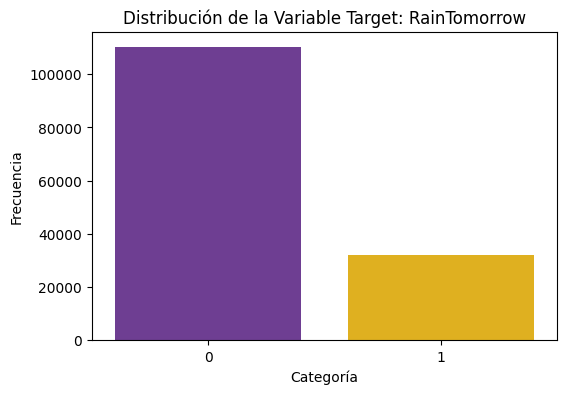

In [46]:
target = 'RainTomorrow'
pos_label = 'Yes'

dataset_cleaned, target, pos_label = step_2_and_3(dataset=dataset_cleaned,
                                                  variable_types=variable_types,
                                                  target=target,
                                                  pos_label=pos_label)

# Paso 4: Selección del modelo y del tamaño del conjunto de entrenamiento

Seleccionar modelo y tamaño del conjunto de entrenamiento

In [47]:
selected_model = 'Regresión Logística'
train_size = 0.8

select_model, train_size = step_4(target=target,
                                  variable_types=variable_types,
                                  selected_model=selected_model,
                                  train_size=train_size)


📌 Paso 4: Selección del Modelo
✅ Modelo confirmado: Regresión Logística
✅ Tamaño del conjunto de entrenamiento: 0.80


# Creación de Subgrupos

In [48]:
# 🌦️ Subgrupos por condiciones meteorológicas

# Lluvias intensas (muy por encima del percentil 75)
subgroup1 = [("Rainfall", "Mayor o igual", 20)]  # 75% ≈ 0.8, máx: 371

# Día seco y caluroso
subgroup2 = [("Rainfall", "Igual", 0), ("MaxTemp", "Mayor o igual", 35)]  # seco total y calor extremo

# Humedad baja por la mañana (percentil 25 ≈ 57)
subgroup3 = [("Humidity9am", "Menor", 40)]

# Alta presión por la tarde (percentil 75 ≈ 1020)
subgroup4 = [("Pressure3pm", "Mayor o igual", 1020)]

# Temperatura mínima bajo cero
subgroup5 = [("MinTemp", "Menor", 0)]

# Temperatura máxima muy baja (frío extremo)
subgroup6 = [("MaxTemp", "Menor", 10)]


# 🌪️ Subgrupos por viento

# Ráfagas de viento muy fuertes (máx = 135)
subgroup7 = [("WindGustSpeed", "Mayor o igual", 70)]


# 🌧️ Combinaciones interesantes

# Lluvia + alta humedad + baja presión
subgroup8 = [("Rainfall", "Mayor o igual", 10), ("Humidity9am", "Mayor", 80), ("Pressure9am", "Menor", 1010)]

# Día cálido con poca humedad
subgroup9 = [("MaxTemp", "Mayor o igual", 30), ("Humidity3pm", "Menor", 40)]

# Día ideal para actividades al aire libre
subgroup10 = [("Rainfall", "Igual", 0), ("MaxTemp", "Entre", (20, 28)), ("Humidity3pm", "Entre", (40, 65)), ("WindSpeed3pm", "Menor o igual", 20)]


# ✅ Lista de todos los subgrupos
list_of_subgroups = [
    subgroup1, subgroup2, subgroup3, subgroup4, subgroup5,
    subgroup6, subgroup7, subgroup8, subgroup9, subgroup10
]

# Paso 5: Selección de Variables Predictoras Fijas y Candidatas + Opción de Manejo de Valores Faltantes


    
    - Opción 1: Eliminar filas con valores faltantes. (missing_data_handling = '1')
    
    - Opción 2: Imputación de valores faltantes (missing_data_handling = '2') (función no disponible)

In [49]:
# Obtener todas las variables predictoras disponibles
available_predictors = [col for col in dataset_cleaned.columns if col != target]

print("Variables predictoras disponibles:")
print(available_predictors)

Variables predictoras disponibles:
['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday']


Seleccionar las variables fijas y predictoras y seleccionar la opción de manejo de valores faltantes.

Marcar variables identificadoras.

In [50]:
fixed_predictors = []
candidate_predictors = ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday']
identificadoras = ['Date']
missing_data_handling = '1'

# Paso 6 y 7: Entrenamiento y Evaluación de Modelos (Principal y Subgrupos)

- Seleccionamos el nivel de restricción de los intervalos de confianza de las métricas de evaluación:
    * **0.99**: MUY restrictivo
    * **0.95**: Restrictivo
    * **0.90**: POCO restrictivo

In [51]:
confidence = 0.95

Evaluamos los modelos.


🌍 Procesando Dataset General...

🚀 Variables predictoras disponibles:
['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday']

📌 Paso 5: Selección de Variables Predictoras

📊 Cantidad de valores nulos por variable seleccionada:
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Temp9am            904
Temp3pm           2726
RainToday         1406
dtype: int64

🔹 Se eliminarán en pasos posteriores los registros con valores faltantes de los predictores que entren en el modelo.

✅ Variables predictoras seleccionadas correctamente.
📌 Máximo 


📊 Matriz de Confusión:


,Predicción 0,Predicción 1
Real 0,16599,2153
Real 1,1791,3444



📈 Métricas del modelo:


,Métrica,Valor,Intervalo de confianza
0,Accuracy,0.84,"[0.83, 0.84]"
1,Precision,0.62,"[0.61, 0.62]"
2,Recall,0.66,"[0.65, 0.66]"
3,Specificity,0.89,"[0.88, 0.89]"
4,F1,0.64,"[0.63, 0.64]"
5,AUC,0.87,"[0.86, 0.87]"


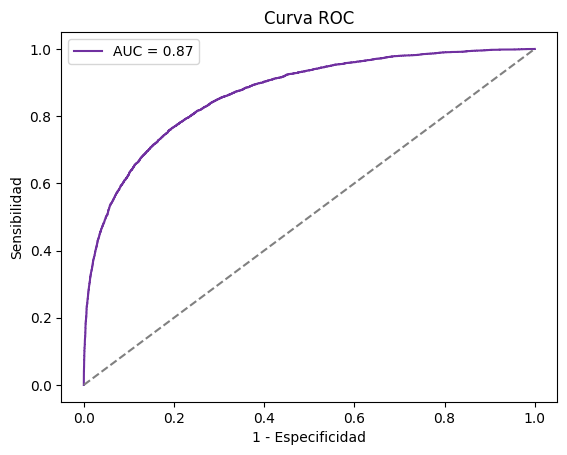

✅ Evaluación completada.

🧪 Procesando Subgrupo 1: [('Rainfall', 'Mayor o igual', 20)]

✅ Filtros aplicados:
 - Rainfall → Mayor o igual: 20

📊 El dataset ha pasado de 142193 filas a 4013 filas después de aplicar los filtros.

🚀 Variables predictoras disponibles:
['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday']

📌 Paso 5: Selección de Variables Predictoras

📊 Cantidad de valores nulos por variable seleccionada:
Location           0
MinTemp           24
MaxTemp            9
Rainfall           0
WindGustDir      318
WindGustSpeed    315
WindDir9am       204
WindDir3pm       134
WindSpeed9am      43
WindSpeed3pm      91
Humidity9am       71
Humidity3pm      150
Pressure9am      442
Pressure3pm      442
Temp9am           44
Temp3pm          128
RainToday          0
dtype: int64

🔹 Se eliminarán en pa


📊 Matriz de Confusión:


,Predicción 0,Predicción 1
Real 0,127,106
Real 1,28,407



📈 Métricas del modelo:


,Métrica,Valor,Intervalo de confianza
0,Accuracy,0.80,"[0.77, 0.83]"
1,Precision,0.79,"[0.76, 0.82]"
2,Recall,0.94,"[0.92, 0.95]"
3,Specificity,0.55,"[0.51, 0.58]"
4,F1,0.86,"[0.83, 0.89]"
5,AUC,0.86,"[0.83, 0.88]"


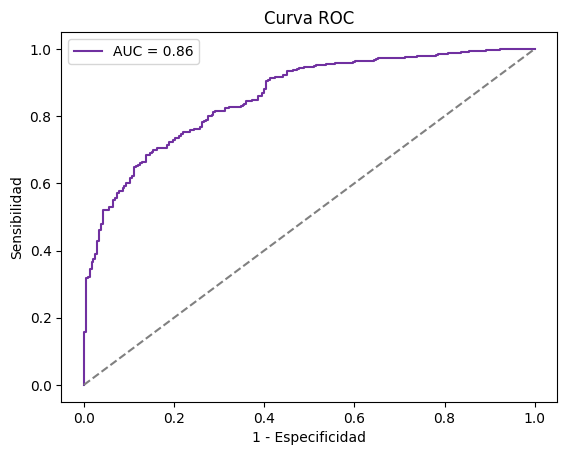

✅ Evaluación completada.

🧪 Procesando Subgrupo 2: [('Rainfall', 'Igual', 0), ('MaxTemp', 'Mayor o igual', 35)]

✅ Filtros aplicados:
 - Rainfall → Igual: 0
 - MaxTemp → Mayor o igual: 35

📊 El dataset ha pasado de 142193 filas a 7444 filas después de aplicar los filtros.

🚀 Variables predictoras disponibles:
['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday']

📌 Paso 5: Selección de Variables Predictoras

📊 Cantidad de valores nulos por variable seleccionada:
Location           0
MinTemp           31
MaxTemp            0
Rainfall           0
WindGustDir      207
WindGustSpeed    207
WindDir9am       214
WindDir3pm        83
WindSpeed9am      33
WindSpeed3pm      73
Humidity9am       66
Humidity3pm      422
Pressure9am      480
Pressure3pm      490
Temp9am           21
Temp3pm          362
RainToday


📊 Matriz de Confusión:


,Predicción 0,Predicción 1
Real 0,4951,344
Real 1,344,416



📈 Métricas del modelo:


,Métrica,Valor,Intervalo de confianza
0,Accuracy,0.89,"[0.88, 0.89]"
1,Precision,0.55,"[0.53, 0.56]"
2,Recall,0.55,"[0.53, 0.56]"
3,Specificity,0.94,"[0.93, 0.94]"
4,F1,0.55,"[0.53, 0.56]"
5,AUC,0.87,"[0.86, 0.88]"


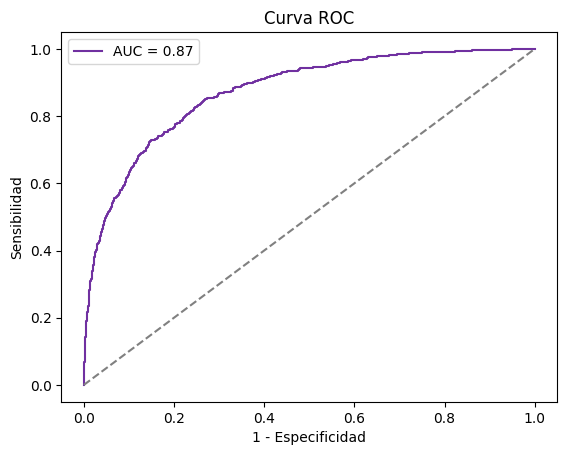

✅ Evaluación completada.

🧪 Procesando Subgrupo 5: [('MinTemp', 'Menor', 0)]

✅ Filtros aplicados:
 - MinTemp → Menor: 0

📊 El dataset ha pasado de 142193 filas a 3406 filas después de aplicar los filtros.

🚀 Variables predictoras disponibles:
['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday']

📌 Paso 5: Selección de Variables Predictoras

📊 Cantidad de valores nulos por variable seleccionada:
Location            0
MinTemp             0
MaxTemp             5
Rainfall           51
WindGustDir       107
WindGustSpeed     107
WindDir9am        864
WindDir3pm        135
WindSpeed9am       75
WindSpeed3pm       85
Humidity9am       153
Humidity3pm        71
Pressure9am      1066
Pressure3pm      1064
Temp9am            99
Temp3pm            69
RainToday          51
dtype: int64

🔹 Se eliminarán en pasos


📊 Matriz de Confusión:


,Predicción 0,Predicción 1
Real 0,1556,187
Real 1,123,95



📈 Métricas del modelo:


,Métrica,Valor,Intervalo de confianza
0,Accuracy,0.84,"[0.83, 0.86]"
1,Precision,0.34,"[0.32, 0.36]"
2,Recall,0.44,"[0.41, 0.46]"
3,Specificity,0.89,"[0.88, 0.91]"
4,F1,0.38,"[0.36, 0.40]"
5,AUC,0.78,"[0.76, 0.80]"


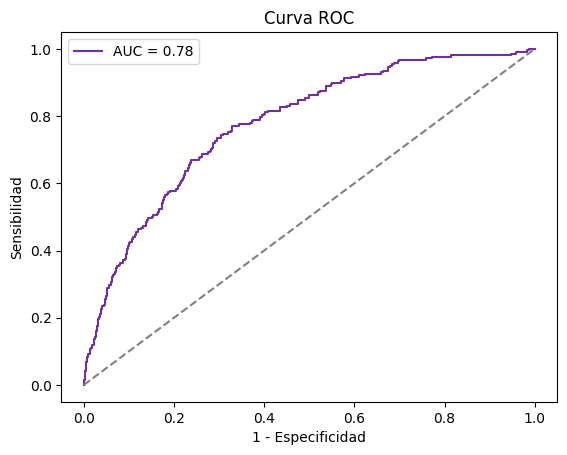

✅ Evaluación completada.


In [52]:
# Procesar dataset general primero
print("\n🌍 Procesando Dataset General...")
modelo_general_results = procesar_dataset(
    dataset=dataset_cleaned,
    variable_types=variable_types,
    target=target,
    candidate_predictors=candidate_predictors,
    identificadoras=identificadoras,
    train_size=train_size,
    confidence=confidence
)

# Procesar todos los subgrupos
subgroup_results = {}

for idx, subgroup_filters in enumerate(list_of_subgroups, start=1):
    print(f"\n🧪 Procesando Subgrupo {idx}: {subgroup_filters}")
    
    dataset_subgroup = filter_dataset(dataset_cleaned, variable_types, subgroup_filters)
    
    if dataset_subgroup.shape[0] >= 100:
        result = procesar_dataset(
            dataset=dataset_subgroup,
            variable_types=variable_types,
            target=target,
            candidate_predictors=candidate_predictors,
            identificadoras=identificadoras,
            train_size=train_size,
            confidence=confidence
        )
        if result is not None:
            subgroup_name = f"Subgrupo {idx}: {generate_subgroup_name(subgroup_filters)}"
            subgroup_results[subgroup_name] = result
    else:
        print(f"⚠️ Subgrupo {idx} descartado (menos de 100 registros).")

# Forest Plot Comparativa General y Subgrupos Generados

Selecciono la métrica que quiero comparar de entre las siguientes y el mínimo valor que debería tomar:

- Accuracy
- Precision
- Recall
- Specificity
- F1
- AUC

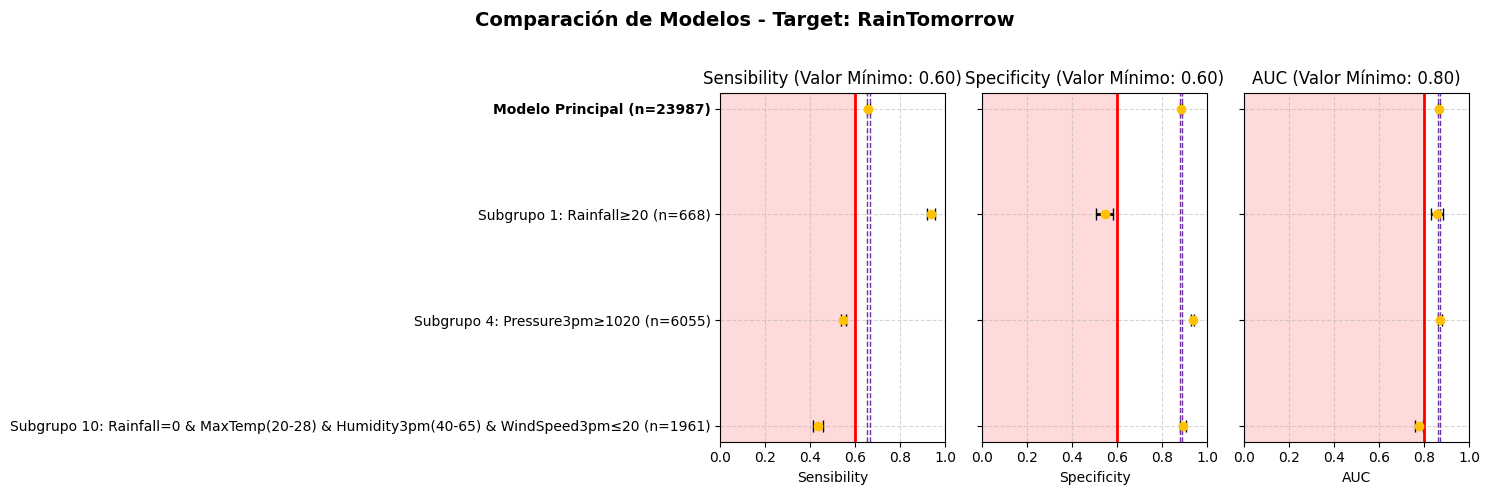

In [56]:
# Definir valores mínimos por métrica
min_values = {"Recall": 0.6, "Specificity": 0.6, "AUC": 0.8}

# Dibujar Forest Plot
forest_plot(
    model_results=modelo_general_results, 
    subgroups_results=subgroup_results, 
    metric_names=["Recall", "Specificity", "AUC"],
    target=target,
    min_values=min_values,
    main_model="Modelo Principal",
    model_name="Comparación de Modelos"
)

In [54]:
end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Tiempo total de ejecución: {minutes} min {seconds} segs")

Tiempo total de ejecución: 4 min 11 segs
